this notebook will be used to show the performance of the first attempt at learning reward.

first load the trained reward network anbd setup methods.

In [1]:
from baselines.common.vec_env import VecFrameStack
from comp300.LearningModel.AgentClasses import *
from baselines.common.cmd_util import make_vec_env
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
import re

/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/patrick/PycharmP

In [4]:
from comp300.LearningModel.getAverageReward import *
env_id = 'BreakoutNoFrameskip-v4'
env_type = 'atari'

env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards': False,
                       'episode_life': False,
                   })
env = VecFrameStack(env, 4)
agent = PPO2Agent(env, 'atari', True)
agent.load("~/models/breakout-reward-RL/breakout_50M_ppo2")
meanR, minR,maxR, std = getAvgReward(agent, env, 20)
print("mean={},min={},max={},std={}".format(meanR,minR,maxR, std))

Logging to /tmp/openai-2020-04-13-14-01-29-747255





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

In [3]:

#load the reward network
trainedNetwork = RewardNetwork("")

trainedNetwork.load_state_dict(torch.load("/home/patrick/models/breakout-reward/fullTest.params"))

#setup the env
model_path = "/home/patrick/models/BreakoutNoFrameskip-v4-groundTruth"
env_id = 'BreakoutNoFrameskip-v4'
env_type = 'atari'

env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards': False,
                       'episode_life': False,
                   })
env = VecFrameStack(env, 4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPO2Agent(env, 'atari', True)
trainedNetwork.to(device)

#run the agent in the env once and save the ground truth reward and observations
def GetDemoFromAgent(agent, network, env):
    trueReward = 0
    learnedReward = 0

    currentReward = 0
    currentObservation = env.reset()
    timeSteps = 0
    done = False

    #run the demo
    while True:
        trueReward += currentReward
        shapedObservation = torch.from_numpy(currentObservation).float().to(device)
        reward, abs_reward = network.predict_reward(shapedObservation)
        learnedReward += reward.tolist()

        action = agent.act(currentObservation,  currentReward, done)
        currentObservation, currentReward, done, info = env.step(action)
        shapedObservations = currentObservation
        timeSteps += 1

        if done:
            trueReward += currentReward
            reward, abs_reward = network.predict_reward(shapedObservation)
            learnedReward += reward.tolist()
            break
    print("{}, {}".format(trueReward, learnedReward))
    return trueReward, learnedReward

#a method to find all the models in a given dir that are just numbers
def Find_all_Models(model_dir):

    checkpoints = []
    filesandDirs = listdir(model_dir)
    allFiles = []
    for i in filesandDirs:
        if isfile(join(model_dir, i)):
            allFiles.append(i)

    for file in allFiles:
        if re.match('^[0-9]+$',file.title()):
            checkpoints.append(file.title())

    return checkpoints




Logging to /tmp/openai-2020-03-02-16-02-57-004450





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


now load all models and run each to get demos to run the network on

In [4]:
trueRewards = []
learnedRewards = []

models = Find_all_Models(model_path)

for model in models:
    agent.load(model_path + "/" + model)
    trueReward, learnedReward = GetDemoFromAgent(agent, trainedNetwork, env)
    tf.keras.backend.clear_session()
    trueRewards.append(trueReward[0])
    learnedRewards.append(learnedReward)
    
maxTrue = max(trueRewards)
maxLearned = max(learnedRewards)
normalisedRewards = learnedRewards / (maxLearned / maxTrue)


[74.], 34.33682805672288
[99.], 65.86631018482149
[302.], 155.02277801930904
[279.], 155.81512496247888
[315.], 93.30423696525395
[311.], 170.5912559516728
[121.], 114.15951220691204
[353.], 184.85370483994484
[262.], 93.91543721966445
[35.], 34.681122524663806
[249.], 105.97182480245829
[324.], 119.3901864271611
[391.], 162.64654493518174
[198.], 130.1735759600997
[78.], 85.31724767759442
[272.], 115.78967253305018
[326.], 133.82854597084224
[338.], 172.42290509678423
[16.], 29.964331537485123
[346.], 193.63260500133038
[278.], 65.52970562689006
[87.], 65.005804002285
[63.], 73.80840286798775
[356.], 172.5038659926504
[339.], 153.47213914059103
[268.], 131.02612023986876
[378.], 78.99928125552833
[38.], 55.73821796104312
[308.], 135.19155960716307
[284.], 97.51030396483839
[313.], 117.40935638360679
[299.], 89.15570707432926
[321.], 136.38481161743402
[302.], 120.03843238018453
[348.], 176.06563959270716
[159.], 132.61132913082838
[298.], 197.3608549963683
[268.], 154.7987414635718
[2

In [8]:
maxTrue = max(trueRewards)
minLearned = min(learnedRewards)
normalisedRewards = [x-minLearned for x in learnedRewards]
copyLearned = []
copyTrue = []
for i in range(len(normalisedRewards)):
    if normalisedRewards[i] > 50000:
        pass
    else:
        copyLearned.append(normalisedRewards[i])
        copyTrue.append(trueRewards[i])
maxLearned = max(copyLearned)
copyLearned = (copyLearned) / (maxLearned / maxTrue)

399.0,212.9364947192371


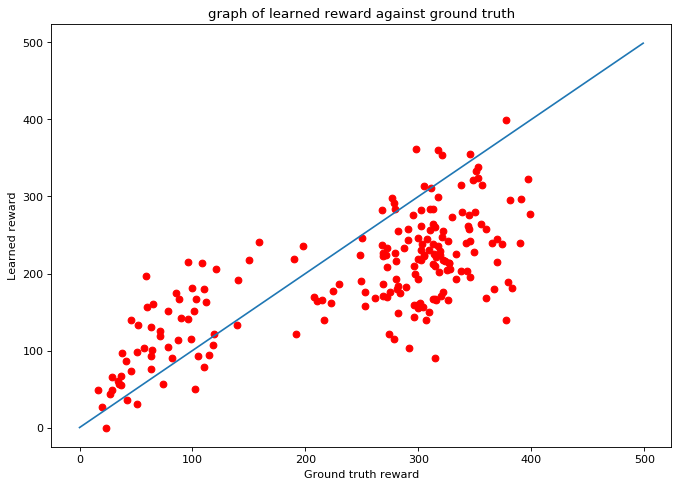

In [15]:
from matplotlib.pyplot import figure

print("{},{}".format(maxTrue, maxLearned))

figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(np.array(copyTrue), np.array(copyLearned), c='r')
plt.plot(np.arange(500), np.arange(500))
plt.ylabel("Learned reward")
plt.xlabel("Ground truth reward")
plt.title("graph of learned reward against ground truth")
plt.show()

In [17]:
minReward = [min(trueRewards)]
maxReward = [max(trueRewards)]
average = [sum(trueRewards) / len(trueRewards)]

from comp300.LearningModel.getAverageReward import *
agent.load("~/models/breakout-reward-RL/breakout_50M_ppo2")
meanR, minR,maxR, std = getAvgReward(agent, env, 20)

minReward.append(minR)
maxReward.append(maxR)
average.append(meanR)


mins: [16.0, 29.0], maxs: [399.0, 391.0], means: [242.77, 255.475]


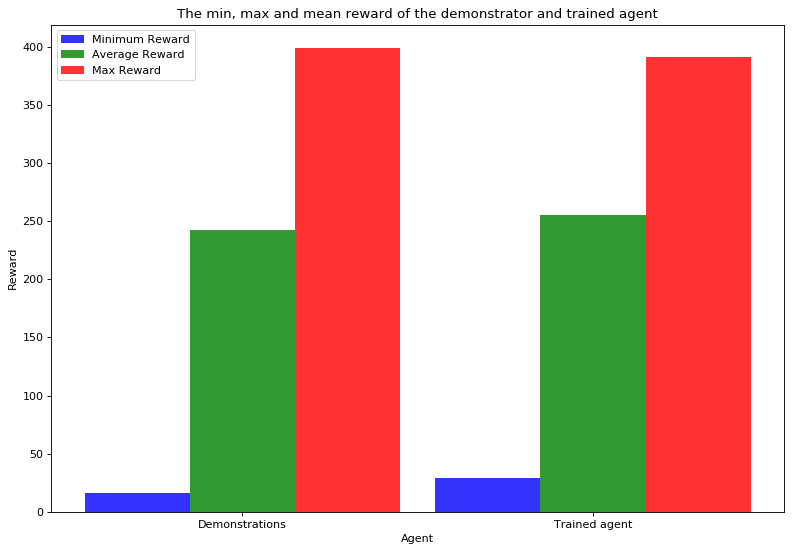

In [19]:
minReward[0] = min(trueRewards)
maxReward[0] = max(trueRewards)
average[0] = sum(trueRewards) /len(trueRewards)
print("mins: {}, maxs: {}, means: {}".format(minReward, maxReward, average))
# create plot
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, minReward, bar_width,
alpha=opacity,
color='b',
label='Minimum Reward')

rects2 = plt.bar(index + bar_width, average, bar_width,
alpha=opacity,
color='g',
label='Average Reward')

rects3 = plt.bar(index + bar_width +bar_width, maxReward, bar_width,
alpha=opacity,
color='r',
label='Max Reward')

plt.xlabel('Agent')
plt.ylabel('Reward')
plt.title('The min, max and mean reward of the demonstrator and trained agent')
plt.xticks(index + bar_width, ('Demonstrations', 'Trained agent'))
plt.legend()

plt.tight_layout()
plt.show()